<a href="https://colab.research.google.com/github/r-meleshko/kaggle/blob/main/plant_seedlings_classification_Ensemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

In [7]:
import gc
import os
import time

import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from google.colab import files
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import inception_v3, xception, inception_resnet_v2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate, Input, Lambda

In [2]:
uploaded = files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c plant-seedlings-classification
!unzip -q plant-seedlings-classification.zip
!ls

 99% 1.68G/1.69G [00:15<00:00, 152MB/s]
100% 1.69G/1.69G [00:15<00:00, 115MB/s]
plant-seedlings-classification.zip  sample_submission.csv  train
sample_data			    test


# Data pre-processing

## Visualize few images and their sizes

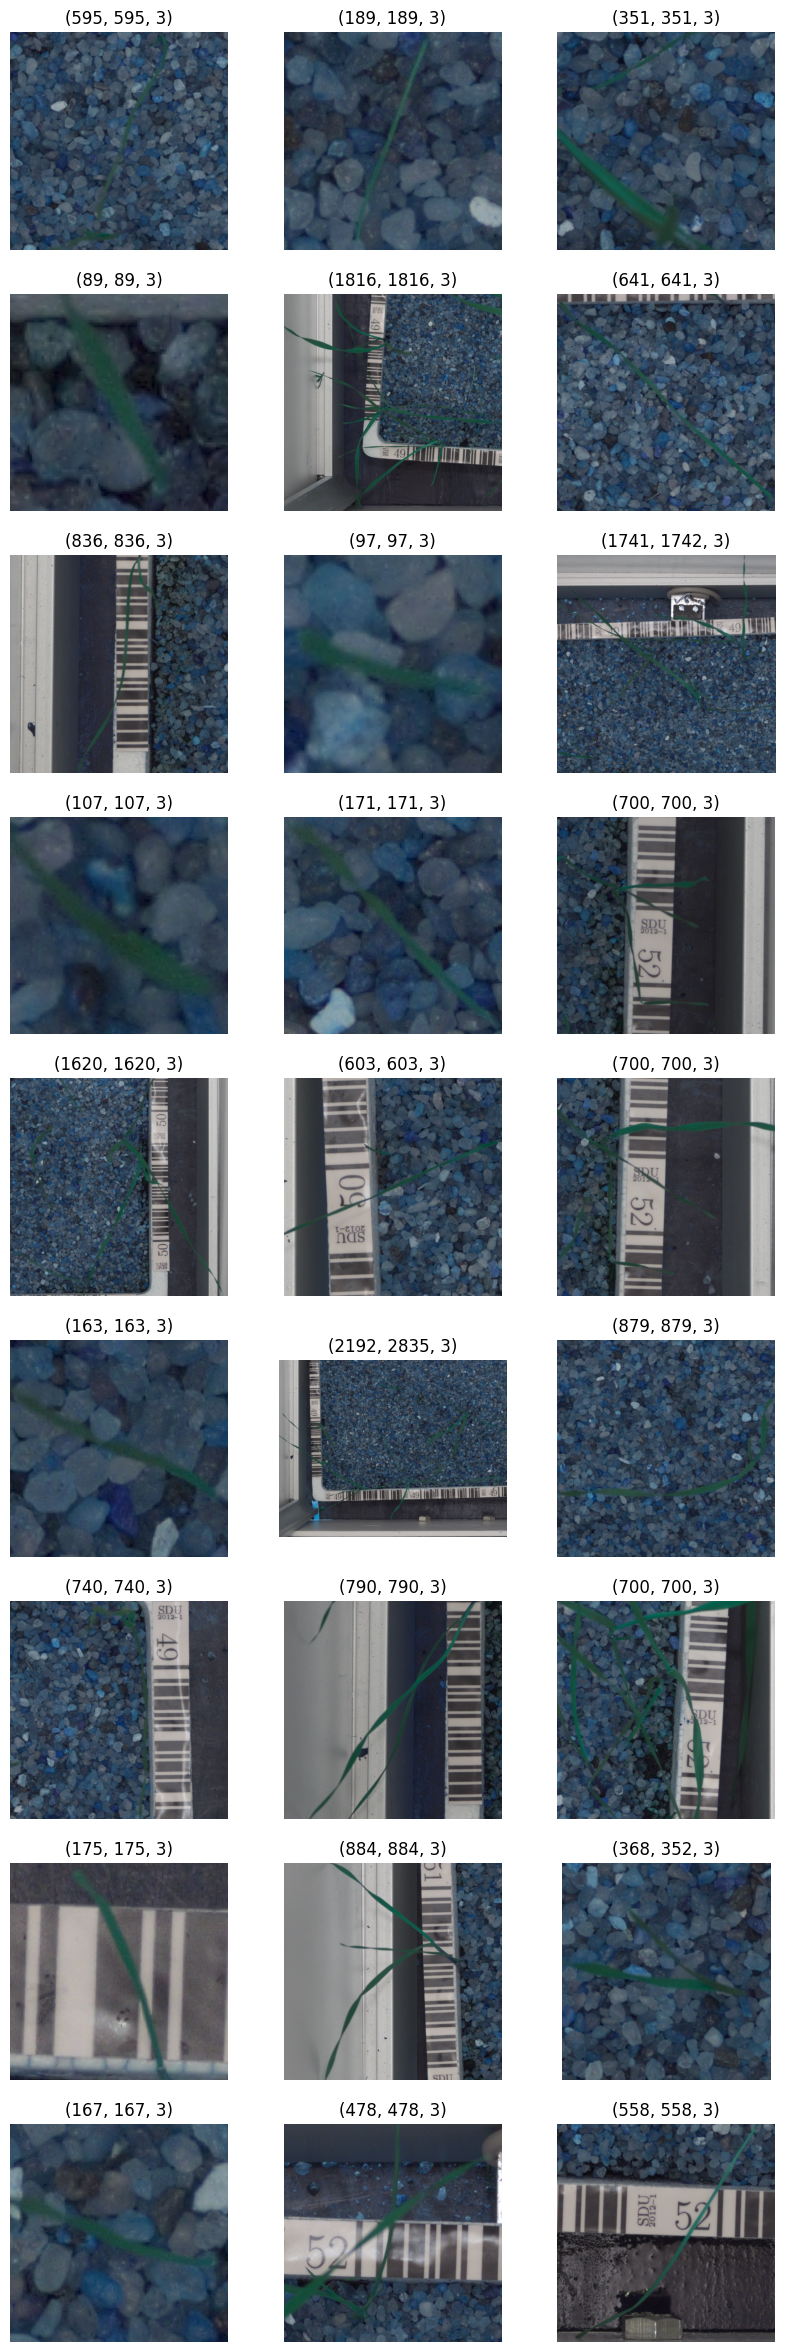

In [ ]:
images_id = os.listdir("train/Black-grass")[:27]

fig, axs = plt.subplots(9, 3, figsize=(10, 30))
for i, img_id in enumerate(images_id):
  row = i // 3
  col = i % 3
  img = cv2.imread(f"train/Black-grass/{img_id}")
  axs[row, col].imshow(img)
  axs[row, col].set_title(img.shape)
  axs[row, col].axis("off")

## Load images

In [4]:
img_size = (299, 299)

X = []
y = []
for iclass in tqdm(os.listdir("train")):
    img_paths = os.listdir(f"train/{iclass}")
    for img_path in img_paths:
        img = cv2.imread(f"train/{iclass}/{img_path}")
        img = cv2.resize(img, img_size)
        X.append(img)
        y.append(iclass)

X, y = np.array(X), np.array(y)
le = LabelEncoder()
Y = le.fit_transform(y)
#Y = to_categorical(Y)

100%|██████████| 12/12 [00:52<00:00,  4.40s/it]


# Model

219055592/219055592 [==============================] - 1s 0us/step


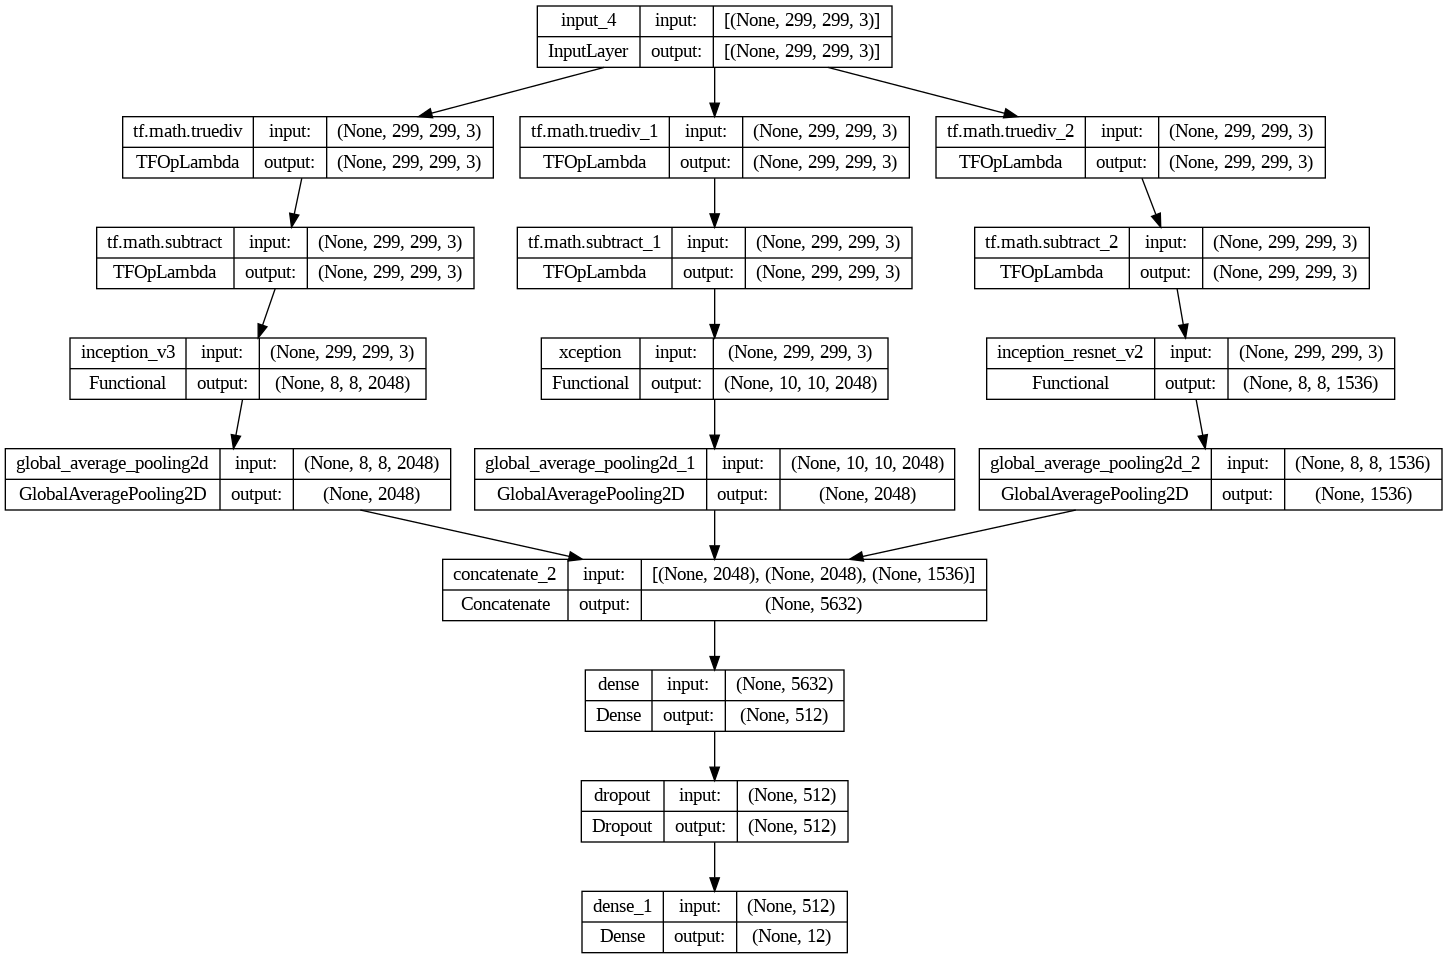

In [5]:
def build_model():
    img_shape = img_size + (3,)
    inception_v3_base = inception_v3.InceptionV3(weights="imagenet", include_top=False, input_shape=img_shape)
    xception_base = xception.Xception(weights="imagenet", include_top=False, input_shape=img_shape)
    inception_resnet_v2_base = inception_resnet_v2.InceptionResNetV2(weights="imagenet", include_top=False, input_shape=img_shape)

    # Ensure the layers of the base models are not trainable
    inception_v3_base.trainable = False
    xception_base.trainable = False
    inception_resnet_v2_base.trainable = False

    # Create a single shared input layer
    inputs = Input(shape=img_shape)

    # Apply model-specific preprocessing, and then call each base model on the shared inputs
    inception_v3_output = inception_v3_base(inception_v3.preprocess_input(inputs))
    xception_output = xception_base(xception.preprocess_input(inputs))
    inception_resnet_v2_output = inception_resnet_v2_base(inception_resnet_v2.preprocess_input(inputs))

    # Concatenate the output from each model
    x = Concatenate()([
        GlobalAveragePooling2D()(inception_v3_output),
        GlobalAveragePooling2D()(xception_output),
        GlobalAveragePooling2D()(inception_resnet_v2_output)
    ])

    # Add the rest of the layers
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(12, activation="softmax")(x)  # Adjust the number of outputs for your specific case

    # Build the final model. Note that the input is the shared input layer.
    model = Model(inputs=inputs, outputs=outputs)

    return model


keras.utils.plot_model(build_model(), "ensemble_learning_diagram.png", show_shapes=True)

In [6]:
splits = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=420).split(X, Y))

trained_models = []
accuracy = []
losses = []
time_callbacks = []

for i, (train_idx, valid_idx) in enumerate(splits):
    print(f"\nStarting fold {i+1}\n")
    x_train_fold = X[train_idx, :]
    y_train_fold = Y[train_idx]
    x_val_fold = X[valid_idx, :]
    y_val_fold = Y[valid_idx]

    model = build_model()

    model.compile("adam", "sparse_categorical_crossentropy", ["accuracy"])

    earlystop = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, min_delta=0.01)
    checkpoint = keras.callbacks.ModelCheckpoint(f"ensemble_learning_model_{i+1}_fold.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
    callbacks_list = [earlystop, checkpoint]

    history = model.fit(
        x_train_fold, y_train_fold,
        batch_size=64,
        epochs=10,
        validation_data = (x_val_fold, y_val_fold),
        callbacks=callbacks_list
    )

    model_res = model.evaluate(x_val_fold, y_val_fold)

    accuracy.append(model_res[1])
    losses.append(model_res[0])
    trained_models.append(model)


Starting fold 1

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 1.8494 - accuracy: 0.4507
Epoch 1: val_accuracy improved from -inf to 0.76705, saving model to ensemble_learning_model_1_fold.h5
50/50 [==============================] - 155s 2s/step - loss: 1.8494 - accuracy: 0.4507 - val_loss: 0.8410 - val_accuracy: 0.7670
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.8711 - accuracy: 0.7100
Epoch 2: val_accuracy improved from 0.76705 to 0.84280, saving model to ensemble_learning_model_1_fold.h5
50/50 [==============================] - 107s 2s/step - loss: 0.8711 - accuracy: 0.7100 - val_loss: 0.5254 - val_accuracy: 0.8428
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.6142 - accuracy: 0.8029
Epoch 3: val_accuracy improved from 0.84280 to 0.86427, saving model to ensemble_learning_model_1_fold.h5
50/50 [==============================] - 91s 2s/step - loss: 0.6142 - accuracy: 0.8029 - val_loss: 0.4412 - val_accuracy: 0.8

In [8]:
del X, Y
gc.collect(0)

img_size = (299, 299)

X_test = []
img_paths = os.listdir("test")
for img_path in tqdm(img_paths):
    img = cv2.imread(f"test/{img_path}")
    img = cv2.resize(img, img_size)
    X_test.append(img)

X_test = np.array(X_test)

100%|██████████| 794/794 [00:03<00:00, 199.96it/s]


In [10]:
y_pred_norm = trained_models[0].predict(X_test, batch_size=128) / 3
for model in trained_models[1:]:
    y_pred_norm += model.predict(X_test, batch_size=128) / 3

y_pred = le.inverse_transform(y_pred_norm.argmax(axis=1))
df = pd.DataFrame({"file": img_paths, "species": y_pred})
df.to_csv('submission.csv', index=False)

7/7 [==============================] - 24s 2s/step


In [23]:
y_pred = le.inverse_transform(y_pred_norm.argmax(axis=1))
df = pd.DataFrame({"file": img_paths, "species": y_pred})
df.to_csv('submission.csv', index=False)

!kaggle competitions submit -c plant-seedlings-classification -f submission.csv -m "InceptionV3, Xception & InceptionResnetV2."
!kaggle competitions submissions -c plant-seedlings-classification

100% 22.3k/22.3k [00:02<00:00, 8.78kB/s]
Successfully submitted to Plant Seedlings ClassificationfileName        date                 description                                 status    publicScore  privateScore  
--------------  -------------------  ------------------------------------------  --------  -----------  ------------  
submission.csv  2023-07-26 17:32:41  InceptionV3, Xception & InceptionResnetV2.  complete  0.89924      0.89924       
submission.csv  2023-07-26 17:31:16  InceptionV3, Xception & InceptionResnetV2.  error                                
